## Predicting gene lenght - multiple regression model

I aim to predict gene length base on the bases composition and chromosome at which the gene is localized. Previous charts do not show a particular pattern, therefor I do not expect a wonderful performance. But let's try anyway.

In [1]:
# Importing modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer, mean_squared_error, median_absolute_error, r2_score
from sklearn.decomposition import PCA

In [2]:
# Importing data from previously saved all_genes_df csv file.
all_genes_df = pd.read_csv('data/all_genes_df.csv')
all_genes_df.head()

,gene_ID,chromosome,gene_length[bp],A_content[%],T_content[%],C_content[%],G_content[%],GC_content[%],category
0,YAL001C,I,3573,35.32046,27.59586,15.81304,21.27064,37.08368,GC content below \nlength above
1,YAL002W,I,3825,31.89542,30.92810,18.74510,18.43137,37.17647,GC content below \nlength above
2,YAL003W,I,987,29.68592,31.10436,18.84498,20.36474,39.20972,GC content below \nlength below
3,YAL005C,I,1929,29.13427,26.80145,21.15086,22.91343,44.06429,GC content above \nlength above
4,YAL007C,I,648,30.86420,32.09877,17.59259,19.44444,37.03703,GC content below \nlength below


Before creating a regression model, it's good to convert non-numeric type of data into numeric type of data, which is the case for chromosomes column. For that, I will use map() function.

In [3]:
chromosome_mapper = {}
for index, value in enumerate(all_genes_df['chromosome'].unique()):
    chromosome_mapper[value] = index + 1
all_genes_df['chromosome'] = all_genes_df['chromosome'].map(chromosome_mapper)

In [4]:
all_genes_df.head()

,gene_ID,chromosome,gene_length[bp],A_content[%],T_content[%],C_content[%],G_content[%],GC_content[%],category
0,YAL001C,1,3573,35.32046,27.59586,15.81304,21.27064,37.08368,GC content below \nlength above
1,YAL002W,1,3825,31.89542,30.92810,18.74510,18.43137,37.17647,GC content below \nlength above
2,YAL003W,1,987,29.68592,31.10436,18.84498,20.36474,39.20972,GC content below \nlength below
3,YAL005C,1,1929,29.13427,26.80145,21.15086,22.91343,44.06429,GC content above \nlength above
4,YAL007C,1,648,30.86420,32.09877,17.59259,19.44444,37.03703,GC content below \nlength below


Done. Let's start building the model. Gene length is going to be predicted based on chromosome number and content of each of the bases - this parameters are potentially more informative than GC content only.

In [5]:
features = all_genes_df.drop(['gene_ID', 'chromosome', 'gene_length[bp]', 'GC_content[%]', 'category'], axis=1)
features.head()

,A_content[%],T_content[%],C_content[%],G_content[%]
0,35.32046,27.59586,15.81304,21.27064
1,31.89542,30.92810,18.74510,18.43137
2,29.68592,31.10436,18.84498,20.36474
3,29.13427,26.80145,21.15086,22.91343
4,30.86420,32.09877,17.59259,19.44444


In [5]:
# Preparing y and X datasets.
y = all_genes_df['gene_length[bp]']
X = all_genes_df.drop(['gene_length[bp]', 'gene_ID', 'category', 'GC_content[%]'], axis=1)

Model building road map:

- polynomial regression model - it's good to check what degree of a polynomial will yield the best results, linear model may not be optimal.

- nested cross-validation as a general good practice in model building. Inner loop done by GridSearchCV() function select optimal parameter (in our case a degree of a polynomial) for the model. Outer loop done by cross_validate() function results in more accurate model evaluation - testing model on several test sets prevents us from overestimating (or underestimating) model performance. To make sure that testing sets are not participating in model training, GridSearchCV() is used as an estimator argument in cross_validate().

- R2 score will be used in GridSearchCV() as a metric for selecting optimal degree for the model.

- I want to know what is the best degree selected by GridSearchCV() during each split done by cross_validate() to see if there is a 'universal' optimal degree for various training sets. For that, I extract the optimal degree for each split by using .best_params_. Results will be stored in best_degrees list.

- several metrics will be used for model evaluation: mean of R2 scores, root mean square errors and median absolute errors and their standard deviations. These parameters will give us more information about model performance.

In [6]:
# Defining an estimator and list of degrees for checking.
poly = PolynomialFeatures()
lin_reg = LinearRegression()
estimator = make_pipeline(poly, lin_reg)

# Selecting parameters for model tuning.
param = {'polynomialfeatures__degree' : [1,2,3,4]}

# Creating best_degrees list for storing best degrees in each cross_validate split.
best_degrees = []

# Preparing metrics for model evaluation on test sets.
scoring = {'r2' : make_scorer(r2_score), \
           'mse' : make_scorer(mean_squared_error), \
           'mae' : make_scorer(median_absolute_error)}

# Performing nested cross-validation. R2 score for model tuning and metrics in scoring for model evaluation.
cv_inner = 10
cv_outer = 10

best_model = GridSearchCV(estimator, param, cv=cv_inner, scoring='r2')
scores = cross_validate(best_model, X, y, cv=cv_outer, scoring=scoring, return_estimator=True)

# Calculating means and standard deviations of each metric scores from splits done by cross_validate().
r2_mean = round((scores['test_r2']).mean(), 2)
r2_std = round((scores['test_r2']).std(), 2)

rmse_mean = round((scores['test_mse']**0.5).mean(), 2) # Extracting roots from mean_squared_errors.
rmse_std = round((scores['test_mse']**0.5).std(), 2)

mae_mean = round((scores['test_mae']).mean(), 2)
mae_std = round((scores['test_mae']).std(), 2)

# Extracting best_params for each cross_validate() (outer loop) split.
for i in range(cv_outer):
    best_degrees.append(scores['estimator'][i].best_params_['polynomialfeatures__degree'])


# Results of the model evaluation
print('Mean R2 score =', r2_mean, "+/-", r2_std)
print('Mean root mean square error =', rmse_mean, "+/-", rmse_std)
print('Mean median absolute error =', mae_mean, "+/-", mae_std)
print('Selected optimal degrees:', best_degrees)

Mean R2 score = 0.12 +/- 0.02
Mean root mean square error = 1070.51 +/- 78.51
Mean median absolute error = 568.66 +/- 23.33
Selected optimal degrees: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


As predicted in data exploration part, my regression model predicting gene length is useless. Standard deviations for each metrics are rather low, which shows that model performs comparably in various tests sets. In each split in outer loop the most optimal degree for model functioning is 3.

The model evaluation is not encouraging, but it is still interesting that the R2 score, despite being very low, is above 0. One would expect that gene length, chromosome localization and bases contents are independent features, but here I show that there is a weak relationship between them. Another interesting finding is that median absolute error is much lower than root mean square error. This means that for some genes model performs much better, having a mistake below 568 bases for 50% of the genes, while for the whole dataset the average error is 1070 bases.

The GridSearchCV() function, in each cross_validate() split, always selected 3 as the optimal degree. I still want to see how model performs for other degrees. I create a loop in which a desired number of degrees will be tested and evaluation metrics (R2 score, root mean square error, median absolute error) will be shown for each degree. A single cross-validation will be performed since we want metrics for each degree. Because data sets are split the same way during each round of cross-validation, degrees will be tested on the same datasets. Below I present results of evaluations of model with various polynomial degrees.

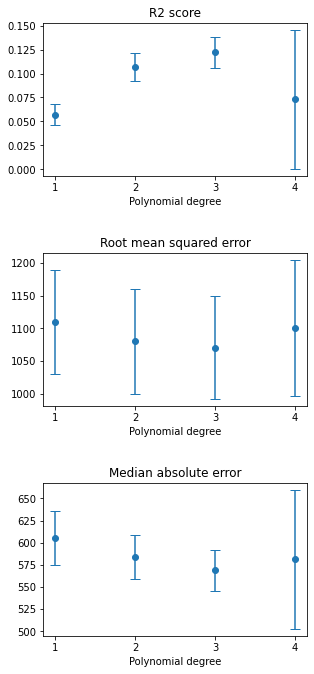

In [14]:
# Defining degrees for testing
degrees = list(range(1, 5))

# Preparing lists for storing metric score means and standard deviations
r2_means = []
rmse_means = []
mae_means = []

r2_std = []
rmse_std = []
mae_std = []


# Loop collecting metric scores for each degree
for deg in degrees:
    poly = PolynomialFeatures(deg)
    lin_reg = LinearRegression()
    estimator = make_pipeline(poly, lin_reg)

    # Preparing metrics
    scoring = {'r2' : make_scorer(r2_score), \
               'mse' : make_scorer(mean_squared_error), \
               'mae' : make_scorer(median_absolute_error)}

    # Cross-validation    
    scores = cross_validate(estimator, X, y, cv=10, scoring=scoring)

    # Appending lists of means and stds
    r2_means.append((scores['test_r2']).mean())
    rmse_means.append((scores['test_mse']**0.5).mean()) # root of mse
    mae_means.append((scores['test_mae']).mean()) # converting for absolute values

    r2_std.append((scores['test_r2']).std())
    rmse_std.append((scores['test_mse']**0.5).std()) # root of mse
    mae_std.append((scores['test_mae']).std()) # converting for absolute values


# Plotting models evaluations
fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.set_size_inches([5, 10])

ax1.errorbar(degrees, r2_means, yerr=r2_std, capsize=5, marker='o', linestyle='none')
ax1.set_title('R2 score')
ax1.set_xticks(degrees)
ax1.set_xlabel('Polynomial degree')

ax2.errorbar(degrees, rmse_means, yerr=rmse_std, capsize=5, marker='o', linestyle='none')
ax2.set_title('Root mean squared error')
ax2.set_xticks(degrees)
ax2.set_xlabel('Polynomial degree')

ax3.errorbar(degrees, mae_means, yerr=mae_std, capsize=5, marker='o', linestyle='none')
ax3.set_title('Median absolute error')
ax3.set_xticks(degrees)
ax3.set_xlabel('Polynomial degree')

plt.tight_layout(pad=3)
plt.savefig('images/regression_evaluation.png', dpi=600)
plt.show()

The chart shows that 3 indeed seems to be optimal degree - not only R2 score is the highest, the errors for other metrics are the lowest.

I played a bit with higher degrees, however above the 4th degree the model becomes very unstable (huge standard deviations) and difference between 1sth and 4th degrees are not visible on the chart, so I leave charts up to the 4th degree only.

Because we did some changes in our data frame (like converting chromosomes to numeric data type), let's save it in a new csv file.

In [18]:
all_genes_df.to_csv('data/all_genes_df_converted.csv', index_label=False)